##### Jonathan Chan
###### Adv. Data Mining
###### Final Project
###### 12/12/2015

###### Project:  Classify handwritten digits

The goal of this project is to take an image of a handwritten single digit and determine its value.  This supervised classification problem data set was taken off of a Kaggle competition.  The link to the competition and dataset can be found [here](https://www.kaggle.com/c/digit-recognizer).

There are two data files for the data set.  The first file is a training set data containing 42000 observations and 785 columns, one of which is the digit label.  The second data set is the test file, containing 28000 observations with 784 columns.  The test data set is what will be used to predict the value and therefore does not include the digit label.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

###### Steps:

1.Import the dataset.   
2.Using the train.csv data, create a train/test split to test the model's effectiveness before fitting the entire data set to predict on the test.csv data.  
3.The data will be tested using four models: Logistic Regression, K Nearest Neighbor, Random Forests, and SVM.    
4.Using the four models, an accuracy measure will be calculated, confusion matrix will be created, and an ROC plot will be displayed.  
5.Fit these models using the entire train data set.  
6.Create the predictions and submit to Kaggle to see each model's accuracy.  
7.Conclusion.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, neighbors, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import numpy as np

###### Step 1:
Now that the standard imports are in, let's import the train.csv and test.csv files.

In [3]:
digits_data = pd.read_csv("./train.csv")

test = pd.read_csv("./test.csv")
#Let's look at what the file looks like. 
digits_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#Separate the labels  from the predictors
X = np.array(digits_data.drop(["label"], axis=1))
y = (digits_data["label"])

###### Step 2:
Take the Train data, and split to 80/20 train/test split to test model.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 5)

I would like to see how each model's ROC curve looks like.  However, since ROC typically looks at binary data, I'll have to binarize the dataset.  To ensure the splits are the same as above, a random state of 5 will be used for both the original data and the binarized data.  

In [5]:
y_roc = label_binarize(y, classes=[0, 1, 2,3,4,5,6,7,8,9])
n_classes = y_roc.shape[1]

X_train_roc, X_test_roc, y_train_roc, y_test_roc = train_test_split(X, y_roc, train_size=0.8, random_state=5)

###### Step 3:  Define a Logistic, KNN, Random forest, and SVM function that will fit the model,  return predictions, calculate accuracy scores, & create a confusion matrix.  A plot_roc function will be created to plot ROC curves for each model.  

In [7]:
#Logisitic Function
def train_logit():
    logit = LogisticRegression(C=1e5)
    logit.fit(X_train, y_train)
    logit_pred = logit.predict(X_test)
    logit_probs = logit.predict_proba(X_test) 
    
    return(logit, logit_pred, logit_probs)

In [8]:
#KNN Function
def train_knn(n):
    knn = neighbors.KNeighborsClassifier(n_neighbors=n) 
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_probs = knn.predict_proba(X_test)
    
    return(knn, knn_pred, knn_probs)

In [9]:
#Random Forest
def train_rf(n):
    rf = RandomForestClassifier(n_estimators=n, criterion='gini', max_depth=None, max_features='sqrt', oob_score=True,verbose=0)
    rf.fit(X_train, y_train)
    rf_test_preds = rf.predict(X_test)
    rf_test_probs = rf.predict_proba(X_test)
    
    return(rf, rf_test_preds, rf_test_probs)

In [10]:
#SVM 
def train_svm(kernel="linear", C=1.0, gamma=0.0):
    svm = SVC(kernel=kernel, C=C, gamma=gamma)
    svm.fit(X_train, y_train)

    # predict on the test set
    y_preds = svm.predict(X_test)
    # get the distances from the hyperplane, the sign of which
    # is the prediction above
    y_dists = svm.decision_function(X_test)
    
    return (svm, y_preds, y_dists)

In [11]:
#Function to plot Roc curves
def plot_roc(classifier):
    #y_score = classifier.fit(X_train_roc, y_train_roc).decision_function(X_test_roc) <- used for svm
    #The 'classifier' obect is a one vs. rest classifier which will learn each class against the others
    y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)
    #Compute the ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    #plot it all
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    print roc_auc_score(y_test_roc, y_score)

###### Step 4:
Now that the functions are defined, I can run and test the models.  
The first model I will try is a simple logistic regression model.  

In [12]:
#Run a logistic regression
logit_train, y_preds_logit, y_probs_logit = train_logit()

In [56]:
#Accuracy score and confusion matrix for logistic regression
logit_acc = accuracy_score(y_test,y_preds_logit)
logit_conf = pd.crosstab(index=y_test, columns=y_preds_logit, rownames=['True'], colnames=['Predicted'])
print logit_conf
print "Classification Report"
print classification_report(y_test, y_preds_logit)
print "Accuracy Score is %s" % logit_acc 

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          774    0    0    2    4    9    6    0    9    2
1            1  914    5    3    1    4    1    0    7    1
2           10   13  704   19   11    8   15   19   19    6
3            3    5   22  789    4   30    3   10   21   11
4            2    5   11    2  735    0    4    3   10   30
5           11    7    4   33    7  622   17    9   31   10
6            9    2   14    1   10   15  758    0    7    0
7            4    4    6    2    5    2    0  846    5   29
8            7   19    4   23    7   21    2    3  678    9
9            8    3    2   16   26    9    0   25   11  790
Classification Report
             precision    recall  f1-score   support

          0       0.93      0.96      0.95       806
          1       0.94      0.98      0.96       937
          2       0.91      0.85      0.88       824
          3       0.89      0.88      0.88   

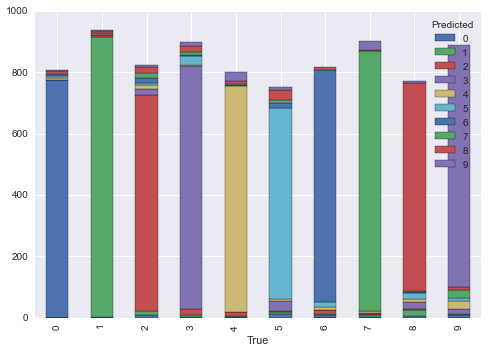

In [14]:
logit_conf.plot(kind = 'bar', stacked = True)

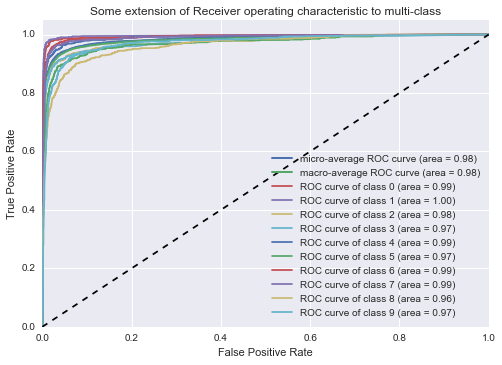

0.981617203975


In [15]:
#To plot the ROC curve, first i'll need to create a classifier.

classifier_logit = OneVsRestClassifier(LogisticRegression(C=1e5))
plot_roc(classifier_logit)

A 91% accuracy score seems pretty good.  Based on the confusion matrix and plot, 1's & 6's have the best accuracy based on the classification report.  On the other hand, 5's have the worst accuracy.  5's seem to be mistaken for 3's and vice versa.  Similarly, 7's and 9's are confused with each other frequently.  The ROC curve shows that the model does a great job at identifying the correct digits.  
Let's try other models and see if the accuracy improves.  

The next model I will try is K nearest neighbor using k = 10.  As this is a classification problem, I'm hoping KNN will provide better results than the logistic regression model.  

In [16]:
#Run K Nearest Neigbor, k = 10
knn_train, y_preds_knn, y_probs_knn = train_knn(10)

In [58]:
#Accuracy score and confusion matrix for K Nearest Neighbor
knn_acc = accuracy_score(y_test,y_preds_knn)
knn_conf = pd.crosstab(index=y_test, columns=y_preds_knn, rownames=['True'], colnames=['Predicted'])
print knn_conf
print classification_report(y_test, y_preds_knn)
print "Accuracy Score is %s" % knn_acc

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          798    1    0    0    1    0    6    0    0    0
1            0  935    0    0    1    0    0    1    0    0
2            7   12  770    4    1    1    2   20    5    2
3            2    4    3  862    1    8    1    8    5    4
4            0    8    0    0  766    0    5    1    0   22
5            2    4    0   16    0  713    7    1    2    6
6           13    1    0    0    1    3  796    0    2    0
7            0    8    1    0    0    0    0  883    0   11
8            3   11    1   12    1   15    5    2  716    7
9            7    6    1    9    8    1    1   10    4  843
             precision    recall  f1-score   support

          0       0.96      0.99      0.97       806
          1       0.94      1.00      0.97       937
          2       0.99      0.93      0.96       824
          3       0.95      0.96      0.96       898
          4   

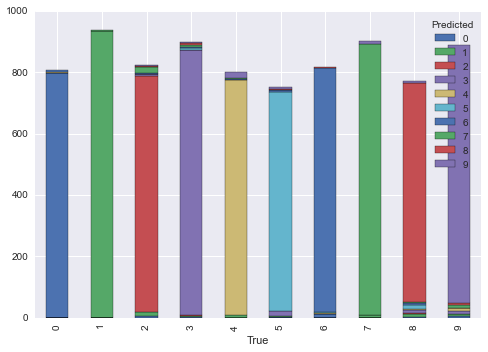

In [18]:
knn_conf.plot(kind = 'bar', stacked = True)

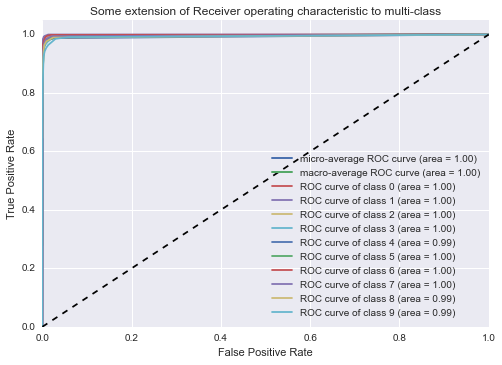

0.996644803233


In [19]:
#To plot the ROC curve, first i'll need to create a classifier.

classifier_knn10 = OneVsRestClassifier(neighbors.KNeighborsClassifier(n_neighbors=10))
plot_roc(classifier_knn10)

At a 96.2% accuracy rate, the KNN model outperforms logistic regression.  Additionally, the AUC score improves over the logit model, and is almost perfect.  Comparing the classification report and confusion matrix with the logisitic model, the KNN model improved across the board.  I tried using GridSearchCV to find the best 'k'.  However, due to the large dataset, the algorithm ran for a day and still didn't complete (even using AWS to run the models took a very long time).  Trying k's of 5 and 10, a k = 5 gave the best accuracy rate at 96.5% (see below). 

In [ ]:
#param_grid = {'n_neighbors':[1,2,5,10,20]}

#knn = neighbors.KNeighborsClassifier() 
#best_neighbors = GridSearchCV(knn, param_grid, cv = 7, refit = True)

#best_neighbors.fit(X_train, y_train)

In [20]:
#Run K Nearest Neigbor, k = 5
knn_train5, y_preds_knn5, y_probs_knn5 = train_knn(5)

In [59]:
knn_acc5 = accuracy_score(y_test,y_preds_knn5)
knn_conf5 = pd.crosstab(index=y_test, columns=y_preds_knn5, rownames=['True'], colnames=['Predicted'])
print knn_conf5
print classification_report(y_test, y_preds_knn5)
print "Accuracy Score is %s" % knn_acc5

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          801    1    0    0    0    0    4    0    0    0
1            0  937    0    0    0    0    0    0    0    0
2            5   10  775    3    1    2    1   23    2    2
3            1    3    4  864    1    9    1    7    4    4
4            0    8    0    0  765    0    4    1    0   24
5            2    4    0   16    0  715    6    2    0    6
6           10    1    0    0    1    4  799    0    1    0
7            0    5    3    0    1    0    0  881    0   13
8            4    8    3   10    1   15    6    3  717    6
9            5    3    2    9    5    2    1    9    2  852
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       806
          1       0.96      1.00      0.98       937
          2       0.98      0.94      0.96       824
          3       0.96      0.96      0.96       898
          4   

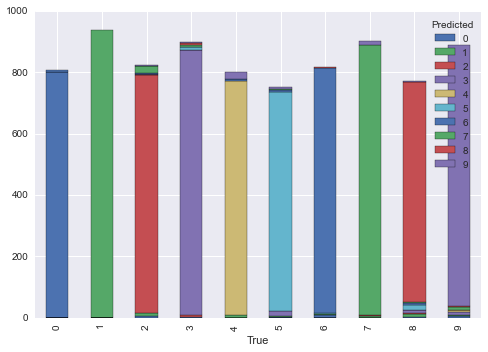

In [22]:
knn_conf5.plot(kind = 'bar', stacked = True)

With a k=5, the accuracy score slightly improved while the AUC slightly declined.  In either case, both k=5 and k=10 had similar results.

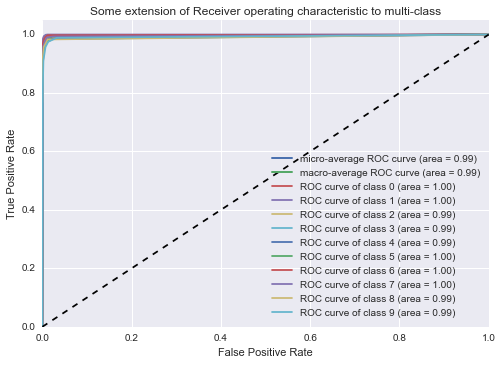

0.994754423919


In [23]:
#To plot the ROC curve, first i'll need to create a classifier.

classifier_knn5 = OneVsRestClassifier(neighbors.KNeighborsClassifier(n_neighbors=5))
plot_roc(classifier_knn5)

The next model is a Random Forest using 1000 trees.  

In [24]:
#Run Random Forest
rf_train, y_preds_rf, y_probs_rf = train_rf(1000)

In [60]:
#Accuracy score and confusion matrix for Random Forest
rf_acc = accuracy_score(y_test, y_preds_rf)
rf_conf = pd.crosstab(index=y_test, columns=y_preds_rf, rownames=['True'], colnames=['Predicted']) 
print rf_conf
print classification_report(y_test, y_preds_rf)
print "Accuracy Score is %s" % rf_acc

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          795    0    0    0    1    0    7    0    3    0
1            0  925    2    6    1    3    0    0    0    0
2            2    1  784    8    6    0    5    9    7    2
3            2    0   10  859    0    7    2    8    5    5
4            0    2    2    0  773    1    3    0    1   20
5            5    1    1   13    1  710    6    2    5    7
6            6    0    0    0    3    5  799    0    3    0
7            0    1    7    0    4    0    0  879    2   10
8            0    2    4    6    2    8    1    2  745    3
9            9    4    2   12   10    1    1    4    9  838
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       806
          1       0.99      0.99      0.99       937
          2       0.97      0.95      0.96       824
          3       0.95      0.96      0.95       898
          4   

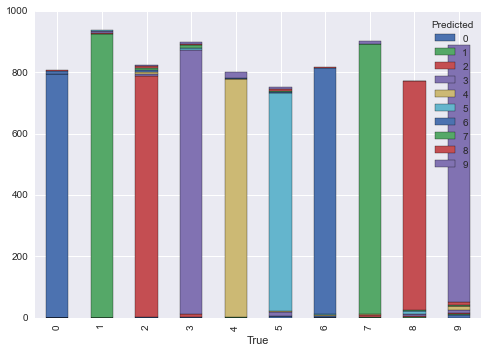

In [26]:
rf_conf.plot(kind = 'bar', stacked = True)

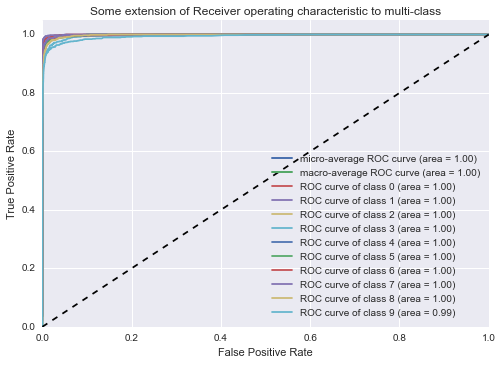

0.998062423555


In [28]:
#To plot the ROC curve, first i'll need to create a classifier.

classifier_rf1000 = OneVsRestClassifier(RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=None, max_features='sqrt', oob_score=True,verbose=0))
plot_roc(classifier_rf1000)

With an accuracy rate of 96.5%, a Random Forest of 1000 trees was slightly outperformed by the KNN model with k = 5.  I will try next a Random Forest with 500 trees.  The AUC score is almost 1, which implies the random forest is doing a great job at classifying the digits.  

In [29]:
#Run Random Forest
rf_train5, y_preds_rf5, y_probs_rf5 = train_rf(500)

In [61]:
#Accuracy score and confusion matrix for Random Forest
rf_acc5 = accuracy_score(y_test, y_preds_rf5)
rf_conf5 = pd.crosstab(index=y_test, columns=y_preds_rf5, rownames=['True'], colnames=['Predicted'])
print rf_conf5
print classification_report(y_test, y_preds_rf5)
print "Accuracy Score is %s" % rf_acc5

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          795    0    0    0    0    0    8    0    3    0
1            0  927    2    5    1    2    0    0    0    0
2            2    2  781    9    6    0    5    8    8    3
3            2    0   11  854    0    9    0    9    7    6
4            0    2    1    0  772    1    4    0    3   19
5            4    1    1   12    1  712    6    2    5    7
6            5    0    0    0    3    6  798    0    4    0
7            0    1    8    1    4    0    0  878    2    9
8            0    2    5    7    2    7    1    2  743    4
9            9    4    2   14   11    1    1    5    7  836
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       806
          1       0.99      0.99      0.99       937
          2       0.96      0.95      0.96       824
          3       0.95      0.95      0.95       898
          4   

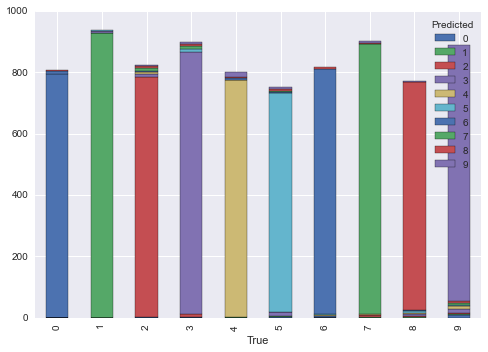

In [31]:
rf_conf5.plot(kind = 'bar', stacked = True)

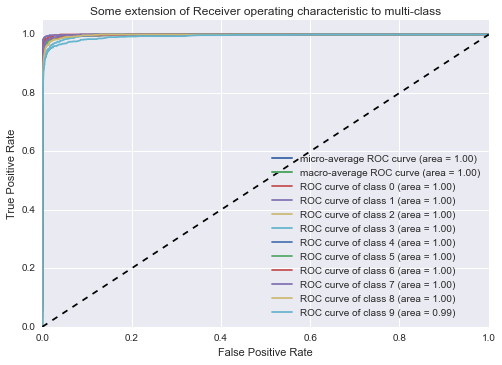

0.998058156165


In [32]:
#To plot the ROC curve, first i'll need to create a classifier.

classifier_rf500 = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, max_features='sqrt', oob_score=True,verbose=0))
plot_roc(classifier_rf500)

With 500 trees, the results were only a little worse than a forest of 1000 trees.  In either case, a Random Forest is a good model, and is comparable to the KNN model with k=5.  Next, I'll try a Support Vector Machine using two different kernel's: Linear and Polynomial.  

In [33]:
#Run an SVM linear Model
svm_linear, y_preds_linear, y_dists_linear = train_svm("linear", C=0.01)

In [62]:
svm_lin_acc = accuracy_score(y_test, y_preds_linear)
svm_lin_conf = pd.crosstab(index=y_test, columns=y_preds_linear, rownames=['True'], colnames=['Predicted'])
print svm_lin_conf
print classification_report(y_test, y_preds_linear)
print "Accuracy Score is %s" % svm_lin_acc

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          784    0    1    2    2    9    5    1    2    0
1            0  921    3    0    1    2    1    1    6    2
2            9   14  735   19   13    6    6    8   13    1
3            4    7   30  790    0   32    1   11   16    7
4            0    5   14    1  741    1    2    6    1   31
5            9    3    8   49    7  638    5    2   22    8
6            8    1   17    3    8   17  758    1    2    1
7            2    4   10   11    7    1    0  833    1   34
8            6   24    9   35    3   24    4    7  653    8
9            7    6    4   11   39    3    0   36   10  774
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       806
          1       0.94      0.98      0.96       937
          2       0.88      0.89      0.89       824
          3       0.86      0.88      0.87       898
          4   

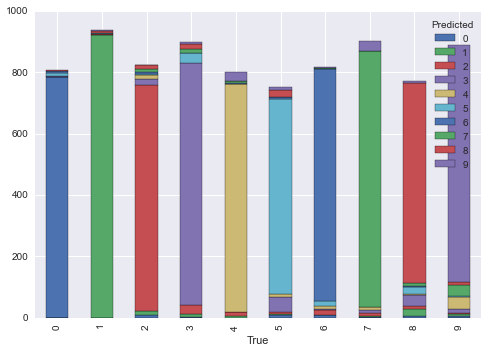

In [35]:
svm_lin_conf.plot(kind = 'bar', stacked = True)

Using a linear kernel with a C = 0.01 gave only 91.2% accuracy rate, which is only slightly better than the logistic regression.  

**Note, I tried using the GridSeach function here as well to see which "C" value was the best.  Unfortunately, this too ran for way too long.  I left it running for over 24 hours and it still didn't finish.  I tried a C=1 and it gave me slightly worse results.  

Next, a polynomial kernel will be used.  

In [ ]:
#param_grid = {"C":[.01, .1, 1, 3, 5, 10]}

#svm = SVC(kernel="linear")
#cv = GridSearchCV(svm, param_grid, cv=5, refit=True)
#cv.fit(X_train, y_train)

In [ ]:
#print cv.best_score_ 
#print cv.best_params_

In [36]:
#Run an SVM polynomial Model with C=.01
svm_poly, y_preds_poly, y_dists_poly = train_svm("poly", C=.01, gamma = 2)

In [63]:
svm_poly_acc = accuracy_score(y_test, y_preds_poly)
svm_poly_conf = pd.crosstab(index=y_test, columns=y_preds_poly, rownames=['True'], colnames=['Predicted'])
print svm_poly_conf
print classification_report(y_test, y_preds_poly)
print "Accuracy score is %s " % svm_poly_acc

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          798    0    0    0    1    1    4    0    2    0
1            0  931    1    3    1    0    0    1    0    0
2            6    1  796    3    3    2    2    5    5    1
3            0    0    8  866    0    8    1    6    6    3
4            0    6    2    0  774    1    2    3    0   14
5            2    1    0   12    1  720    2    0    4    9
6            8    0    2    0    2   11  792    0    1    0
7            1    3    2    0    3    0    0  886    0    8
8            1    4    1    5    3    6    2    2  747    2
9            9    3    1    4    6    2    0    4    4  857
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       806
          1       0.98      0.99      0.99       937
          2       0.98      0.97      0.97       824
          3       0.97      0.96      0.97       898
          4   

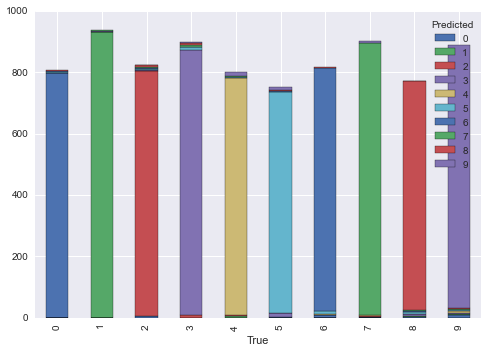

In [38]:
svm_poly_conf.plot(kind = 'bar', stacked = True)

This result is the best yet with a 97.2% accuracy rate.  Next is the ROC plot.  I will redefine a function to plot as an SVM has a decision function instead of a 'proba' function.  

In [41]:
#Function to plot Roc curves
def plot_rocsvm(classifier):
    y_score = classifier.fit(X_train_roc, y_train_roc).decision_function(X_test_roc)
    #y_score = classifier.fit(X_train_roc, y_train_roc).predict_proba(X_test_roc)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_roc.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    print roc_auc_score(y_test_roc, y_score)

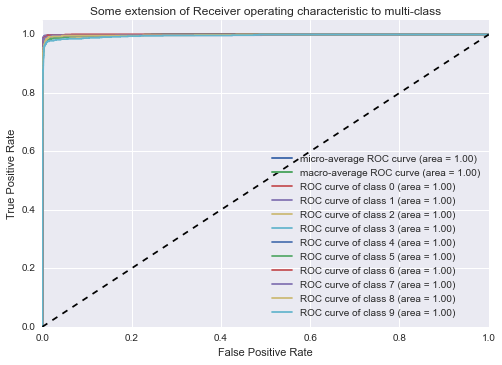

0.998412558981


In [44]:
classifier_svmpoly = OneVsRestClassifier(SVC(kernel="poly", C=0.01, gamma=2))
plot_rocsvm(classifier_svmpoly)

In [45]:
#Run an SVM polynomial Model with C=.01
svm_poly3, y_preds_poly3, y_dists_poly3 = train_svm("poly", C=.01, gamma = 3)

In [64]:
svm_poly_acc3 = accuracy_score(y_test, y_preds_poly3)
svm_poly_conf3 = pd.crosstab(index=y_test, columns=y_preds_poly3, rownames=['True'], colnames=['Predicted'])
print svm_poly_conf3
print classification_report(y_test, y_preds_poly3)
print "Accuracy score is %s " % svm_poly_acc3

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          798    0    0    0    1    1    4    0    2    0
1            0  931    1    3    1    0    0    1    0    0
2            6    1  796    3    3    2    2    5    5    1
3            0    0    8  866    0    8    1    6    6    3
4            0    6    2    0  774    1    2    3    0   14
5            2    1    0   12    1  720    2    0    4    9
6            8    0    2    0    2   11  792    0    1    0
7            1    3    2    0    3    0    0  886    0    8
8            1    4    1    5    3    6    2    2  747    2
9            9    3    1    4    6    2    0    4    4  857
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       806
          1       0.98      0.99      0.99       937
          2       0.98      0.97      0.97       824
          3       0.97      0.96      0.97       898
          4   

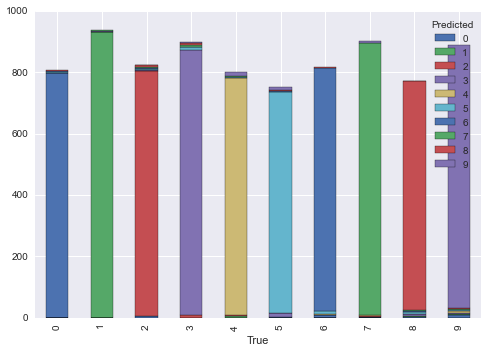

In [47]:
svm_poly_conf3.plot(kind = 'bar', stacked = True)

Using a polynomial kernel, the results improved drastically from a linear kernel.  Additionally, this model so far has given me the best accuracy rate and AUC score. There was no difference between a gamma of 2 and 3, nor was there a difference with a C=1 versus a C=0.1(see below).  

In [48]:
#Run an SVM polynomial Model with C=1
svm_poly11, y_preds_poly11, y_dists_poly11 = train_svm("poly", C=1, gamma = 2)

In [65]:
svm_poly_acc11 = accuracy_score(y_test, y_preds_poly11)
svm_poly_conf11 = pd.crosstab(index=y_test, columns=y_preds_poly11, rownames=['True'], colnames=['Predicted'])
print svm_poly_conf11
print classification_report(y_test, y_preds_poly11)
print "Accuracy score is %s " % svm_poly_acc11

Predicted    0    1    2    3    4    5    6    7    8    9
True                                                       
0          798    0    0    0    1    1    4    0    2    0
1            0  931    1    3    1    0    0    1    0    0
2            6    1  796    3    3    2    2    5    5    1
3            0    0    8  866    0    8    1    6    6    3
4            0    6    2    0  774    1    2    3    0   14
5            2    1    0   12    1  720    2    0    4    9
6            8    0    2    0    2   11  792    0    1    0
7            1    3    2    0    3    0    0  886    0    8
8            1    4    1    5    3    6    2    2  747    2
9            9    3    1    4    6    2    0    4    4  857
             precision    recall  f1-score   support

          0       0.97      0.99      0.98       806
          1       0.98      0.99      0.99       937
          2       0.98      0.97      0.97       824
          3       0.97      0.96      0.97       898
          4   

Based on the results of the four models tested, the SVM model gave the best overall result.  Because we split the train data into train/test, there could be overfitting.  The best way to tell is to test it on the actual test data. I will refit all the models using the entire train data, predict the test data, and submit each result to Kaggle and see how the accuracy turns out. Based on my test models, I expect SVM to have the best resutls with the logistic model having the worst.    

###### Step 5: 

Train entire 'train.cvs' data.

In [34]:
#Before refitting the data, separate the labels from the rest of the train data
digits_data = digits_data.values

train = digits_data[:, 1:]
labels = digits_data[:, :1]

###### Step 6:

Make predictions on each model and submit to kaggle.

In [35]:
#Create the logistic classifier
logit_full = LogisticRegression(C=1e5)
logit_full.fit(train, labels)

C:\Users\Jonathan\Anaconda2\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0)

In [36]:
#logisitic predictions
pred_log_labels = logit_full.predict(test) #predicing the test points

In [37]:
#Create the csv to submit to Kaggle
pred_log_labels = pd.DataFrame(pred_log_labels)

pred_log_labels['ImageId'] = pred_log_labels.index + 1
pred_log_labels = pred_log_labels[['ImageId', 0]]
pred_log_labels.columns = ['ImageId', 'Label']

pred_log_labels.to_csv('logpred.csv', index=False)

In [38]:
#Create the knn classifier with k = 5 as that was the slighlty better model between the k=10 knn model.
knn_full = neighbors.KNeighborsClassifier(n_neighbors=5) 
knn_full.fit(train, labels)

C:\Users\Jonathan\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [39]:
#Knn predictions
pred_knn_labels = knn_full.predict(test) #predicing the test points

In [40]:
#Create the csv to submit to Kaggle
pred_knn_labels = pd.DataFrame(pred_knn_labels)

pred_knn_labels['ImageId'] = pred_knn_labels.index + 1
pred_knn_labels = pred_knn_labels[['ImageId', 0]]
pred_knn_labels.columns = ['ImageId', 'Label']

pred_knn_labels.to_csv('knnpred5.csv', index=False)

In [60]:
#Create the random forest classifier with 500 trees.  
rf_full = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, max_features='sqrt', oob_score=True,verbose=0)
rf_full.fit(train, labels)

C:\Users\Jonathan\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [61]:
#Random Forest predictions
pred_rf_labels = rf_full.predict(test) #predicing the test points

In [62]:
#Create the csv to submit to Kaggle
pred_rf_labels = pd.DataFrame(pred_rf_labels)

pred_rf_labels['ImageId'] = pred_rf_labels.index + 1
pred_rf_labels = pred_rf_labels[['ImageId', 0]]
pred_rf_labels.columns = ['ImageId', 'Label']

pred_rf_labels.to_csv('rfpred.csv', index=False)

In [63]:
#Create the svm polynomial classifier  
svm_poly = SVC(kernel="poly", C=0.01, gamma=2)
svm_poly.fit(train, labels)

C:\Users\Jonathan\Anaconda2\lib\site-packages\sklearn\svm\base.py:472: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y_ = column_or_1d(y, warn=True)


SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=2,
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [64]:
#SVM predictions
pred_svm_labels = svm_poly.predict(test) #predicing the test points

In [65]:
#Create the csv to submit to Kaggle
pred_svm_labels = pd.DataFrame(pred_svm_labels)

pred_svm_labels['ImageId'] = pred_svm_labels.index + 1
pred_svm_labels = pred_svm_labels[['ImageId', 0]]
pred_svm_labels.columns = ['ImageId', 'Label']

pred_svm_labels.to_csv('svmpred.csv', index=False)

###### Step 7:

Conclusion

Below are my Kaggle Results:

Logistic Regression - .90729 ~ 91% accuracy.  
KNN - .968    
Random Forest - .967  
SVM - .97543

As expected from our original models, SVM gave the best score...Currently, I'm in 308th place.  